### Program written by Pablo Sánchez-Palencia, 2021
Scope: To check correlation between bandgaps calculated with DFT at GGA and HSE levels.

In [1]:
### USER INPUT REQUIRED ###

# Windows path
repodir = r'C:\Users\pablo\OneDrive\Documentos\GitHub\GeSn2N4-ML'

In [2]:
# Import modules.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score

In [3]:
# Read DFT derived energies from .csv file to data frame.
hse_energies = pd.read_csv(repodir + "\\repository_data\\vasp-hseenergies.csv", header=None)
gga_energies = pd.read_csv(repodir + "\\repository_data\\vasp-energies.csv", header=None)
hse_energies.columns = ['tag','HSE-BGE']
gga_energies.columns = ['label','inversion','SCF','BGE']
#Look for indexes of hse structures within the gga df
with open(repodir + '\\repository_data\\gga_structures_list.txt', "r") as obj_file: 
    list_gga00 = obj_file.read().splitlines()
list_gga=[i.zfill(4) for i in list_gga00]
list_hse=[i[-4:] for i in hse_energies['tag']]
indexes_gga=[list_gga.index(i) for i in list_hse]
gaps=np.array(gga_energies['BGE'][indexes_gga])
hse_energies['GGA-BGE']=gaps
inversion_rate=np.array(gga_energies['inversion'][indexes_gga])
hse_energies['y_inversion']=inversion_rate

In [4]:
#Monolinear model (only GGA bandgaps as input)
x=np.array(hse_energies['GGA-BGE']).reshape(-1,1)
y=np.array(hse_energies['HSE-BGE']).reshape(-1,1)
model_mono = linear_model.LinearRegression()
model_mono.fit(x,y)
y_pred = model_mono.predict(x)
mpe_wo=np.mean(np.abs((y-y_pred) / y)) * 100
mae_wo=mean_absolute_error(y, y_pred)*1000
maxe_wo=max(abs(y-y_pred))*1000
r2_wo=r2_score(y,y_pred)
print('Mean absolute error {} meV'.format(mae_wo))
print('Mean percentage error {}%'.format(mpe_wo))
print('R2 {} '.format(r2_wo))
print('Max absolute error {} meV'.format(maxe_wo))
print(model_mono.coef_)
print(model_mono.intercept_)

Mean absolute error 7.489867888618904 meV
Mean percentage error 0.40387857407875793%
R2 0.9862469251760088 
Max absolute error [29.53092508] meV
[[1.05047872]]
[1.04058528]


In [5]:
#Bilinear model (GGA bandgaps + inversion degree as inputs)
xx=hse_energies[['GGA-BGE','y_inversion']]
yy=hse_energies['HSE-BGE']
model_bi = linear_model.LinearRegression()
model_bi.fit(xx,yy)
yy_pred = model_bi.predict(xx)
mpe_wi=np.mean(np.abs((yy-yy_pred) / yy)) * 100
mae_wi=mean_absolute_error(yy, yy_pred)*1000
maxe_wi=max(abs(yy-yy_pred))*1000
r2_wi=r2_score(yy,yy_pred)
print('Mean absolute error {} meV'.format(mae_wi))
print('Mean percentage error {}%'.format(mpe_wi))
print('R2 {} '.format(r2_wi))
print('Max absolute error {} meV'.format(maxe_wi))
print(model_bi.coef_)
print(model_bi.intercept_)

Mean absolute error 1.5314818599778792 meV
Mean percentage error 0.08208892786013297%
R2 0.9994438062324439 
Max absolute error 5.681841131571996 meV
[ 1.08248836 -0.04680858]
1.044979437918063


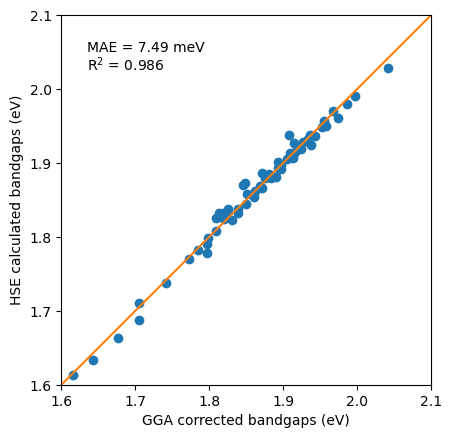

In [6]:
plt.figure()
eje=np.linspace(min(y_pred),max(y_pred))
eje=np.linspace(1.6,2.1)
plt.xlim([1.6,2.1])
plt.ylim([1.6,2.1])
plt.plot(y_pred,y,'o')
plt.plot(eje,eje)
plt.xlabel('GGA corrected bandgaps (eV)')
plt.ylabel('HSE calculated bandgaps (eV)')
ax=plt.gca()
ax.set_aspect('equal', adjustable='box')
xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()
xtags=xmin+0.07*(xmax-xmin)
yperc=np.array([0.9,0.85,0.8,0.75,0.7,0.65,0.6])
ytags=ymin+yperc*(ymax-ymin)
plt.text(xtags,ytags[0], "MAE = "+'%.2f' % (mae_wo) +" meV")
#plt.text(xtags,ytags[1], "MPE = "+'%.3f' % (mpe_wix) +"%")
plt.text(xtags,ytags[1], r'R$^2$ = '+'%.3f' % r2_wo)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

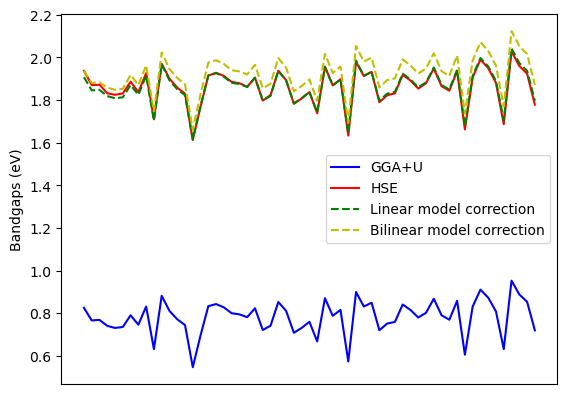

In [10]:
plt.plot(hse_energies['GGA-BGE'],'b')
plt.plot(hse_energies['HSE-BGE'],'r')
plt.plot(model_mono.coef_[0]*hse_energies['GGA-BGE']+model_mono.intercept_[0],'g--')
plt.plot(model_bi.coef_[0]*hse_energies['GGA-BGE']-model_bi.coef_[1]*hse_energies['y_inversion']+model_bi.intercept_,'y--')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.ylabel("Bandgaps (eV)")
plt.legend(["GGA+U","HSE","Linear model correction","Bilinear model correction"])
plt.show()
plt.close()